# Import Libraries and Data

In [148]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import datetime
from matplotlib import rcParams
from sklearn.preprocessing import LabelEncoder
from scipy import stats
sns.set(style = "white",color_codes = True)

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

In [149]:
pd.set_option('display.max_columns', None)

In [150]:
df_transactions = pd.read_csv('../input/final-project-ds/transactions.csv')
df_customer = pd.read_csv('../input/final-project-ds/customer.csv')

In [151]:
df_transaction = pd.read_csv('../input/final-project-ds/transactions.csv')

In [152]:
df_transactions['created_at'] = pd.to_datetime(df_transactions['created_at'], infer_datetime_format=True, utc = True)
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'], infer_datetime_format=True, utc = True)
df_transactions = df_transactions.loc[(df_transactions["created_at"] >= "2021-05-01") & (df_transactions["created_at"] <= "2021-10-31")].copy()
df_transaction = df_transaction.loc[(df_transaction["created_at"] >= "2021-05-01") & (df_transaction["created_at"] <= "2021-10-31")].copy()

# Feature Engineering

In [153]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131630 entries, 23 to 852579
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   created_at              131630 non-null  datetime64[ns, UTC]
 1   customer_id             131630 non-null  int64              
 2   booking_id              131630 non-null  object             
 3   session_id              131630 non-null  object             
 4   product_metadata        131630 non-null  object             
 5   payment_method          131630 non-null  object             
 6   payment_status          131630 non-null  object             
 7   promo_amount            131630 non-null  int64              
 8   promo_code              46968 non-null   object             
 9   shipment_fee            131630 non-null  int64              
 10  shipment_date_limit     131630 non-null  object             
 11  shipment_location_lat   1

In [154]:
df_transactions['customer_id'].nunique()

31359

In [155]:
df_transactions['product_metadata'] = df_transactions['product_metadata'].replace({'\[{':'','\}]':'','\'':'','\:':',','\{':'','\},':';'}, regex=True)

In [156]:
df=df_transactions[['product_metadata']]

In [157]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [158]:
df_transactions=explode(df_transactions.assign(product_metadata=df_transactions['product_metadata'].str.split(';')), 'product_metadata')

In [159]:
df_transactions[['id_n','product_id','q_n','quantity','p_n','item_price']] = df_transactions.product_metadata.str.split(",", expand=True)
df_transactions=df_transactions.drop(columns = ['id_n', 'q_n', 'p_n'])
df_transactions.head(20)

,booking_id,created_at,customer_id,payment_method,payment_status,promo_amount,promo_code,session_id,shipment_date_limit,shipment_fee,shipment_location_lat,shipment_location_long,total_amount,product_metadata,product_id,quantity,item_price
0,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,2021-05-29 10:59:02.365620,4774,Credit Card,Success,0,NaN,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,2021-06-03T18:15:49.265999Z,10000,-7.154563,110.855725,164335,"product_id, 6572, quantity, 1, item_price, 154335",6572,1,154335
1,57b61173-4837-449a-a5fb-22b0cd07d56d,2021-07-15 11:06:17.365620,4774,LinkAja,Success,6325,AZ2022,b0ab036c-5c29-417b-9c2e-1a41d872028a,2021-07-17T19:21:39.314719Z,10000,-3.122690,126.418906,75865,"product_id, 18001, quantity, 1, item_price, 72190",18001,1,72190
2,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,2021-08-31 11:05:02.365620,4774,Credit Card,Success,0,NaN,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,2021-09-05T15:37:35.476812Z,10000,-1.300594,111.913009,2091956,"product_id, 10460, quantity, 4, item_price, 39...",10460,4,398497
3,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,2021-08-31 11:05:02.365620,4774,Credit Card,Success,0,NaN,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,2021-09-05T15:37:35.476812Z,10000,-1.300594,111.913009,2091956,"product_id, 31208, quantity, 1, item_price, 4...",31208,1,487968
4,6a32b1ef-142a-41f8-8046-f9b74676233d,2021-10-17 11:45:13.365620,4774,Credit Card,Success,2752,WEEKENDSERU,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,2021-10-22T05:58:33.933514Z,10000,-7.502613,108.741192,450657,"product_id, 2334, quantity, 1, item_price, 443409",2334,1,443409
5,c01d6e80-565d-4b1b-b83b-e91c11162b4d,2021-05-14 18:28:36.162570,58191,OVO,Success,4705,AZ2022,8d35e4af-ab63-4a74-983c-af88f1a85152,2021-05-19T09:43:44.162717Z,15000,-3.479745,119.197729,543773,"product_id, 5358, quantity, 3, item_price, 177826",5358,3,177826
6,be247299-a9d3-4d67-a713-65502beb821a,2021-05-29 18:20:03.162570,58191,OVO,Success,0,NaN,f2d56994-ceea-4fea-af5c-803466d8580e,2021-06-04T14:23:31.498175Z,10000,-7.522017,110.828926,3671806,"product_id, 26653, quantity, 1, item_price, 18...",26653,1,182874
7,be247299-a9d3-4d67-a713-65502beb821a,2021-05-29 18:20:03.162570,58191,OVO,Success,0,NaN,f2d56994-ceea-4fea-af5c-803466d8580e,2021-06-04T14:23:31.498175Z,10000,-7.522017,110.828926,3671806,"product_id, 8665, quantity, 2, item_price, 24...",8665,2,248462
8,be247299-a9d3-4d67-a713-65502beb821a,2021-05-29 18:20:03.162570,58191,OVO,Success,0,NaN,f2d56994-ceea-4fea-af5c-803466d8580e,2021-06-04T14:23:31.498175Z,10000,-7.522017,110.828926,3671806,"product_id, 18971, quantity, 1, item_price, 4...",18971,1,411403
9,be247299-a9d3-4d67-a713-65502beb821a,2021-05-29 18:20:03.162570,58191,OVO,Success,0,NaN,f2d56994-ceea-4fea-af5c-803466d8580e,2021-06-04T14:23:31.498175Z,10000,-7.522017,110.828926,3671806,"product_id, 11705, quantity, 1, item_price, 4...",11705,1,424764


In [160]:
df = df_customer.merge(df_transaction, on='customer_id', how='right')
df.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,Success,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,Success,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865


In [161]:
df_ct = df[['customer_id','first_join_date','created_at']]
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131630 entries, 0 to 131629
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   customer_id      131630 non-null  int64              
 1   first_join_date  131630 non-null  object             
 2   created_at       131630 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 4.0+ MB


In [162]:
df_ct = df_ct.sort_values('created_at').groupby('customer_id').tail(1)

In [163]:
# # One Hot Encoding Kolom payment_method
# df_m = pd.concat([df_m, pd.get_dummies(df_m.payment_method, prefix='payment_method')], axis=1)
# df_m

In [164]:
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,Success,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,Success,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-08-31 11:05:02.365620+00:00,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,"[{'product_id': 10460, 'quantity': 4, 'item_pr...",Credit Card,Success,0,NaN,10000,2021-09-05T15:37:35.476812Z,-1.300594,111.913009,2091956
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-10-17 11:45:13.365620+00:00,6a32b1ef-142a-41f8-8046-f9b74676233d,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,"[{'product_id': 2334, 'quantity': 1, 'item_pri...",Credit Card,Success,2752,WEEKENDSERU,10000,2021-10-22T05:58:33.933514Z,-7.502613,108.741192,450657
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-05-14 18:28:36.162570+00:00,c01d6e80-565d-4b1b-b83b-e91c11162b4d,8d35e4af-ab63-4a74-983c-af88f1a85152,"[{'product_id': 5358, 'quantity': 3, 'item_pri...",OVO,Success,4705,AZ2022,15000,2021-05-19T09:43:44.162717Z,-3.479745,119.197729,543773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131625,12282,Harjaya,Hutapea,565e61a7-ad1c-462b-bae1-62c921be1e0a,565e61a7_ad1c_462b_bae1_62c921be1e0a@startupca...,M,1993-08-23,iOS,e574ec97-8274-45c5-90a0-d2a7f2ef2b79,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-3.103494,129.877977,Maluku,Indonesia,2019-06-13,2021-07-14 23:29:15.048756+00:00,0725904c-6d1d-4dbc-9dd3-15a8c9ba5d6d,b22de41d-ce48-4036-a022-93668dacfc5b,"[{'product_id': 27216, 'quantity': 1, 'item_pr...",Debit Card,Success,1148,BUYMORE,10000,2021-07-16T14:40:40.114778Z,-6.175613,106.699361,503219
131626,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2021-06-22 05:50:07.359304+00:00,11c3a08c-8b5c-41ca-8d7c-ff01030866a6,d04c2020-fef1-4fea-868f-84a222298d59,"[{'product_id': 44712, 'quantity': 1, 'item_pr...",OVO,Success,3598,AZ2022,0,2021-06-25T13:41:40.714248Z,-6.939718,111.256057,260386
131627,37287,Edi,Mandala,a6b1f57d-4085-4b00-97a0-50f252ca00

In [165]:
# One Hot Encoding Kolom payment_method
df = pd.concat([df, pd.get_dummies(df.payment_method, prefix='payment_method')], axis=1)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,Success,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335,1,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,Success,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865,0,0,0,1,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-08-31 11:05:02.365620+00:00,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,"[{'product_id': 10460, 'quantity': 4, 'item_pr...",Credit Card,Success,0,NaN,10000,2021-09-05T15:37:35.476812Z,-1.300594,111.913009,2091956,1,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-10-17 11:45:13.365620+00:00,6a32b1ef-142a-41f8-8046-f9b74676233d,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,"[{'product_id': 2334, 'quantity': 1, 'item_pri...",Credit Card,Success,2752,WEEKENDSERU,10000,2021-10-22T05:58:33.933514Z,-7.502613,108.741192,450657,1,0,0,0,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-05-14 18:28:36.162570+00:00,c01d6e80-565d-4b1b-b83b-e91c11162b4d,8d35e4af-ab63-4a74-983c-af88f1a85152,"[{'product_id': 5358, 'quantity': 3, 'item_pri...",OVO,Success,4705,AZ2022,15000,2021-05-19T09:43:44.162717Z,-3.479745,119.197729,543773,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131625,12282,Harjaya,Hutapea,565e61a7-ad1c-462b-bae1-62c921be1e0a,565e61a7_ad1c_462b_bae1_62c921be1e0a@startupca...,M,1993-08-23,iOS,e574ec97-8274-45c5-90a0-d2a7f2ef2b79,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-3.103494,129.877977,Maluku,Indonesia,2019-06-13,2021-07-14 23:29:15.048756+00:00,0725904c-6d1d-4dbc-9dd3-15a8c9ba5d6d,b22de41d-ce48-4036-a022-93668dacfc5b,"[{'product_id': 27216, 'quantity': 1, 'item_pr...",Debit Card,Success,1148,BUYMORE,10000,2021-07-16T14:40:40.114778Z,-6.175613,106.699361,503219,0,1,0,0,0
131626,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_169b49e1e1d1@startupca...,F,1992-12-19,Android,7f3dc335-38e0-4ee8-9c08-3d8918e785a4,Android 2.2,-6.939718,111.256057,Jawa Tengah,Indonesia,2020-05-13,2021-06-22 05:50:07.359304+00:00,11c3a08c-8b5c-41ca-8d7c-ff01030866a6,d04c2020-fef1-4fea-868f-84a222298d

In [166]:
df = pd.concat([df, pd.get_dummies(df.promo_code, prefix='promo_code')], axis=1)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,Success,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,Success,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865,0,0,0,1,0,1,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-08-31 11:05:02.365620+00:00,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,"[{'product_id': 10460, 'quantity': 4, 'item_pr...",Credit Card,Success,0,NaN,10000,2021-09-05T15:37:35.476812Z,-1.300594,111.913009,2091956,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-10-17 11:45:13.365620+00:00,6a32b1ef-142a-41f8-8046-f9b74676233d,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,"[{'product_id': 2334, 'quantity': 1, 'item_pri...",Credit Card,Success,2752,WEEKENDSERU,10000,2021-10-22T05:58:33.933514Z,-7.502613,108.741192,450657,1,0,0,0,0,0,0,0,0,0,0,1,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-05-14 18:28:36.162570+00:00,c01d6e80-565d-4b1b-b83b-e91c11162b4d,8d35e4af-ab63-4a74-983c-af88f1a85152,"[{'product_id': 5358, 'quantity': 3, 'item_pri...",OVO,Success,4705,AZ2022,15000,2021-05-19T09:43:44.162717Z,-3.479745,119.197729,543773,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131625,12282,Harjaya,Hutapea,565e61a7-ad1c-462b-bae1-62c921be1e0a,565e61a7_ad1c_462b_bae1_62c921be1e0a@startupca...,M,1993-08-23,iOS,e574ec97-8274-45c5-90a0-d2a7f2ef2b79,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-3.103494,129.877977,Maluku,Indonesia,2019-06-13,2021-07-14 23:29:15.048756+00:00,0725904c-6d1d-4dbc-9dd3-15a8c9ba5d6d,b22de41d-ce48-4036-a022-93668dacfc5b,"[{'product_id': 27216, 'quantity': 1, 'item_pr...",Debit Card,Success,1148,BUYMORE,10000,2021-07-16T14:40:40.114778Z,-6.175613,106.699361,503219,0,1,0,0,0,0,1,0,0,0,0,0,0
131626,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-16

In [167]:
# Label Encoding Kolom payment_status
payment_status = {'Success': 1, 'Failed': 0}
df['payment_status'] = df['payment_status'].map(payment_status)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,1,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,1,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865,0,0,0,1,0,1,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-08-31 11:05:02.365620+00:00,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,"[{'product_id': 10460, 'quantity': 4, 'item_pr...",Credit Card,1,0,NaN,10000,2021-09-05T15:37:35.476812Z,-1.300594,111.913009,2091956,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-10-17 11:45:13.365620+00:00,6a32b1ef-142a-41f8-8046-f9b74676233d,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,"[{'product_id': 2334, 'quantity': 1, 'item_pri...",Credit Card,1,2752,WEEKENDSERU,10000,2021-10-22T05:58:33.933514Z,-7.502613,108.741192,450657,1,0,0,0,0,0,0,0,0,0,0,1,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-05-14 18:28:36.162570+00:00,c01d6e80-565d-4b1b-b83b-e91c11162b4d,8d35e4af-ab63-4a74-983c-af88f1a85152,"[{'product_id': 5358, 'quantity': 3, 'item_pri...",OVO,1,4705,AZ2022,15000,2021-05-19T09:43:44.162717Z,-3.479745,119.197729,543773,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131625,12282,Harjaya,Hutapea,565e61a7-ad1c-462b-bae1-62c921be1e0a,565e61a7_ad1c_462b_bae1_62c921be1e0a@startupca...,M,1993-08-23,iOS,e574ec97-8274-45c5-90a0-d2a7f2ef2b79,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-3.103494,129.877977,Maluku,Indonesia,2019-06-13,2021-07-14 23:29:15.048756+00:00,0725904c-6d1d-4dbc-9dd3-15a8c9ba5d6d,b22de41d-ce48-4036-a022-93668dacfc5b,"[{'product_id': 27216, 'quantity': 1, 'item_pr...",Debit Card,1,1148,BUYMORE,10000,2021-07-16T14:40:40.114778Z,-6.175613,106.699361,503219,0,1,0,0,0,0,1,0,0,0,0,0,0
131626,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_1

In [168]:
df_PST = df[['customer_id','payment_status']]
df_PST['payment_status'] = df_PST.groupby('customer_id')['payment_status'].transform('mean')
df_PST=df_PST.drop_duplicates('customer_id')
df_PST

,customer_id,payment_status
0,4774,1.0
4,58191,1.0
16,24915,1.0
17,76966,1.0
30,56690,1.0
...,...,...
131623,32621,0.5
131625,12282,1.0
131626,64772,1.0
131627,37287,1.0


In [169]:
df_PA = df[['customer_id','promo_amount']]
df_PA['promo_amount'] = df_PA.groupby('customer_id')['promo_amount'].transform('mean')
df_PA=df_PA.drop_duplicates('customer_id')
df_PA

,customer_id,promo_amount
0,4774,2269.250000
4,58191,2007.416667
16,24915,4915.000000
17,76966,1441.384615
30,56690,2783.500000
...,...,...
131623,32621,1743.000000
131625,12282,1148.000000
131626,64772,3598.000000
131627,37287,2530.000000


In [170]:
df_PMC = df[['customer_id','payment_method_Credit Card']]
df_PMC['payment_method_Credit_Card'] = df_PMC.groupby('customer_id')['payment_method_Credit Card'].transform('sum')
df_PMC=df_PMC.drop_duplicates('customer_id')
df_PMC

,customer_id,payment_method_Credit Card,payment_method_Credit_Card
0,4774,1,3
4,58191,0,0
16,24915,0,0
17,76966,1,11
30,56690,1,1
...,...,...,...
131623,32621,0,0
131625,12282,0,0
131626,64772,0,0
131627,37287,0,0


In [171]:
# pmdc = payment methods debit card
df_PMDC = df[['customer_id','payment_method_Debit Card']]
df_PMDC['payment_method_Debit_Card'] = df_PMDC.groupby('customer_id')['payment_method_Debit Card'].transform('sum')
df_PMDC=df_PMDC.drop_duplicates('customer_id')
df_PMDC

,customer_id,payment_method_Debit Card,payment_method_Debit_Card
0,4774,0,0
4,58191,0,0
16,24915,0,0
17,76966,0,1
30,56690,0,0
...,...,...,...
131623,32621,0,0
131625,12282,1,1
131626,64772,0,0
131627,37287,0,0


In [172]:
# payment methods gopay
df_PMG = df[['customer_id','payment_method_Gopay']]
df_PMG['payment_method_Gopay'] = df_PMG.groupby('customer_id')['payment_method_Gopay'].transform('sum')
df_PMG=df_PMG.drop_duplicates('customer_id')
df_PMG

,customer_id,payment_method_Gopay
0,4774,0
4,58191,2
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [173]:
# payment methods linkaja
df_PMLA = df[['customer_id','payment_method_LinkAja']]
df_PMLA['payment_method_LinkAja'] = df_PMLA.groupby('customer_id')['payment_method_LinkAja'].transform('sum')
df_PMLA=df_PMLA.drop_duplicates('customer_id')
df_PMLA

,customer_id,payment_method_LinkAja
0,4774,1
4,58191,0
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [174]:
# payment methods ovo
df_PMO = df[['customer_id','payment_method_OVO']]
df_PMO['payment_method_OVO'] = df_PMO.groupby('customer_id')['payment_method_OVO'].transform('sum')
df_PMO=df_PMO.drop_duplicates('customer_id')
df_PMO

,customer_id,payment_method_OVO
0,4774,0
4,58191,10
16,24915,1
17,76966,1
30,56690,1
...,...,...
131623,32621,2
131625,12282,0
131626,64772,1
131627,37287,2


In [175]:
df_PCAZ = df[['customer_id','promo_code_AZ2022']]
df_PCAZ['promo_code_AZ2022'] = df_PCAZ.groupby('customer_id')['promo_code_AZ2022'].transform('sum')
df_PCAZ=df_PCAZ.drop_duplicates('customer_id')
df_PCAZ

,customer_id,promo_code_AZ2022
0,4774,1
4,58191,1
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,1
131627,37287,1


In [176]:
df_PCBY = df[['customer_id','promo_code_BUYMORE']]
df_PCBY['promo_code_BUYMORE'] = df_PCBY.groupby('customer_id')['promo_code_BUYMORE'].transform('sum')
df_PCBY=df_PCBY.drop_duplicates('customer_id')
df_PCBY

,customer_id,promo_code_BUYMORE
0,4774,0
4,58191,1
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,1
131625,12282,1
131626,64772,0
131627,37287,0


In [177]:
df_PCLD = df[['customer_id','promo_code_LIBURDONG']]
df_PCLD['promo_code_LIBURDONG'] = df_PCLD.groupby('customer_id')['promo_code_LIBURDONG'].transform('sum')
df_PCLD=df_PCLD.drop_duplicates('customer_id')
df_PCLD

,customer_id,promo_code_LIBURDONG
0,4774,0
4,58191,0
16,24915,0
17,76966,1
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [178]:
df_PCSC = df[['customer_id','promo_code_SC2022']]
df_PCSC['promo_code_SC2022'] = df_PCSC.groupby('customer_id')['promo_code_SC2022'].transform('sum')
df_PCSC=df_PCSC.drop_duplicates('customer_id')
df_PCSC

,customer_id,promo_code_SC2022
0,4774,0
4,58191,0
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [179]:
df_PCST = df[['customer_id','promo_code_STARTUP']]
df_PCST['promo_code_STARTUP'] = df_PCST.groupby('customer_id')['promo_code_STARTUP'].transform('sum')
df_PCST=df_PCST.drop_duplicates('customer_id')
df_PCST

,customer_id,promo_code_STARTUP
0,4774,0
4,58191,0
16,24915,0
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [180]:
df_PCWM = df[['customer_id','promo_code_WEEKENDMANTAP']]
df_PCWM['promo_code_WEEKENDMANTAP'] = df_PCWM.groupby('customer_id')['promo_code_WEEKENDMANTAP'].transform('sum')
df_PCWM=df_PCWM.drop_duplicates('customer_id')
df_PCWM 

,customer_id,promo_code_WEEKENDMANTAP
0,4774,0
4,58191,0
16,24915,0
17,76966,2
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [181]:
df_PCWS = df[['customer_id','promo_code_WEEKENDSERU']]
df_PCWS['promo_code_WEEKENDSERU'] = df_PCWS.groupby('customer_id')['promo_code_WEEKENDSERU'].transform('sum')
df_PCWS=df_PCWS.drop_duplicates('customer_id')
df_PCWS 

,customer_id,promo_code_WEEKENDSERU
0,4774,1
4,58191,0
16,24915,0
17,76966,3
30,56690,1
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [182]:
df_PCXX = df[['customer_id','promo_code_XX2022']]
df_PCXX['promo_code_XX2022'] = df_PCXX.groupby('customer_id')['promo_code_XX2022'].transform('sum')
df_PCXX=df_PCXX.drop_duplicates('customer_id')
df_PCXX 

,customer_id,promo_code_XX2022
0,4774,0
4,58191,1
16,24915,1
17,76966,0
30,56690,0
...,...,...
131623,32621,0
131625,12282,0
131626,64772,0
131627,37287,0


In [183]:
df_pm = df_PCXX.merge(df_PCWS, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCWM, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCST, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCSC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCLD, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCBY, on='customer_id', how='left')
df_pm = df_pm.merge(df_PCAZ, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMO, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMLA, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMG, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMDC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PMC, on='customer_id', how='left')
df_pm = df_pm.merge(df_PA, on='customer_id', how='left')
df_pm = df_pm.merge(df_PST, on='customer_id', how='left')

In [184]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 31359 non-null  int64  
 1   promo_code_XX2022           31359 non-null  uint8  
 2   promo_code_WEEKENDSERU      31359 non-null  uint8  
 3   promo_code_WEEKENDMANTAP    31359 non-null  uint8  
 4   promo_code_STARTUP          31359 non-null  uint8  
 5   promo_code_SC2022           31359 non-null  uint8  
 6   promo_code_LIBURDONG        31359 non-null  uint8  
 7   promo_code_BUYMORE          31359 non-null  uint8  
 8   promo_code_AZ2022           31359 non-null  uint8  
 9   payment_method_OVO          31359 non-null  uint8  
 10  payment_method_LinkAja      31359 non-null  uint8  
 11  payment_method_Gopay        31359 non-null  uint8  
 12  payment_method_Debit Card   31359 non-null  uint8  
 13  payment_method_Debit_Card   313

In [185]:
df_pm.isnull().sum()

customer_id                   0
promo_code_XX2022             0
promo_code_WEEKENDSERU        0
promo_code_WEEKENDMANTAP      0
promo_code_STARTUP            0
promo_code_SC2022             0
promo_code_LIBURDONG          0
promo_code_BUYMORE            0
promo_code_AZ2022             0
payment_method_OVO            0
payment_method_LinkAja        0
payment_method_Gopay          0
payment_method_Debit Card     0
payment_method_Debit_Card     0
payment_method_Credit Card    0
payment_method_Credit_Card    0
promo_amount                  0
payment_status                0
dtype: int64

In [186]:
df_pm

,customer_id,promo_code_XX2022,promo_code_WEEKENDSERU,promo_code_WEEKENDMANTAP,promo_code_STARTUP,promo_code_SC2022,promo_code_LIBURDONG,promo_code_BUYMORE,promo_code_AZ2022,payment_method_OVO,payment_method_LinkAja,payment_method_Gopay,payment_method_Debit Card,payment_method_Debit_Card,payment_method_Credit Card,payment_method_Credit_Card,promo_amount,payment_status
0,4774,0,1,0,0,0,0,0,1,0,1,0,0,0,1,3,2269.250000,1.0
1,58191,1,0,0,0,0,0,1,1,10,0,2,0,0,0,0,2007.416667,1.0
2,24915,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4915.000000,1.0
3,76966,0,3,2,0,0,1,0,0,1,0,0,0,1,1,11,1441.384615,1.0
4,56690,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,2783.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31354,32621,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1743.000000,0.5
31355,12282,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1148.000000,1.0
31356,64772,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3598.000000,1.0
31357,37287,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,2530.000000,1.0


In [187]:
df_pm.promo_code_XX2022.fillna(0, inplace = True)
df_pm.promo_code_WEEKENDSERU.fillna(0, inplace = True)
df_pm.promo_code_WEEKENDMANTAP.fillna(0, inplace = True)
df_pm.promo_code_STARTUP.fillna(0, inplace = True)
df_pm.promo_code_SC2022.fillna(0, inplace = True)
df_pm.promo_code_LIBURDONG.fillna(0, inplace = True)
df_pm.promo_code_BUYMORE.fillna(0, inplace = True)
df_pm.promo_code_AZ2022.fillna(0, inplace = True)
df_pm.payment_method_OVO.fillna(0, inplace = True)
df_pm.payment_method_LinkAja.fillna(0, inplace = True)
df_pm.payment_method_Gopay.fillna(0, inplace = True)
df_pm.payment_method_Debit_Card.fillna(0, inplace = True)
df_pm.payment_method_Credit_Card.fillna(0, inplace = True)
df_pm.promo_amount.fillna(0, inplace = True)
df_pm.payment_status.fillna(0, inplace = True)

In [188]:
df_pm.payment_status.fillna(0, inplace = True)

In [189]:
df_pm['promo_amount'].fillna(0, inplace = True)

In [190]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 31359 non-null  int64  
 1   promo_code_XX2022           31359 non-null  uint8  
 2   promo_code_WEEKENDSERU      31359 non-null  uint8  
 3   promo_code_WEEKENDMANTAP    31359 non-null  uint8  
 4   promo_code_STARTUP          31359 non-null  uint8  
 5   promo_code_SC2022           31359 non-null  uint8  
 6   promo_code_LIBURDONG        31359 non-null  uint8  
 7   promo_code_BUYMORE          31359 non-null  uint8  
 8   promo_code_AZ2022           31359 non-null  uint8  
 9   payment_method_OVO          31359 non-null  uint8  
 10  payment_method_LinkAja      31359 non-null  uint8  
 11  payment_method_Gopay        31359 non-null  uint8  
 12  payment_method_Debit Card   31359 non-null  uint8  
 13  payment_method_Debit_Card   313

In [191]:
#yang bagus cuma promo amount sama payment status, jadi yg dipake itu doang
df_pm = df_pm[['customer_id','promo_amount','payment_status']]

In [192]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     31359 non-null  int64  
 1   promo_amount    31359 non-null  float64
 2   payment_status  31359 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 980.0 KB


In [193]:
# error

In [194]:
# df_m

In [195]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 75346 to 57916
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      31359 non-null  int64              
 1   first_join_date  31359 non-null  object             
 2   created_at       31359 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 980.0+ KB


In [196]:
# df_ct['created_at']=df_ct['created_at'].fillna(df_ct['first_join_date'])

In [197]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 75346 to 57916
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      31359 non-null  int64              
 1   first_join_date  31359 non-null  object             
 2   created_at       31359 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 980.0+ KB


In [198]:
df_ct['first_join_date'] = pd.to_datetime(df_ct['first_join_date'], infer_datetime_format=True, utc = True)

In [199]:
df_ct['created_at']=pd.to_datetime(df_ct['created_at'], format = '%Y-%m-%d ',utc=True)

In [200]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 75346 to 57916
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      31359 non-null  int64              
 1   first_join_date  31359 non-null  datetime64[ns, UTC]
 2   created_at       31359 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1)
memory usage: 980.0 KB


In [201]:
#durasi bertahan = jarak first join date ke terakhir beli
df_ct['durasi_bertahan'] = (df_ct['created_at'] - df_ct['first_join_date']).dt.days

In [202]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 75346 to 57916
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      31359 non-null  int64              
 1   first_join_date  31359 non-null  datetime64[ns, UTC]
 2   created_at       31359 non-null  datetime64[ns, UTC]
 3   durasi_bertahan  31359 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(2)
memory usage: 1.2 MB


In [203]:
df_ct=df_ct.drop(columns =['first_join_date','created_at'])

In [204]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 75346 to 57916
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   customer_id      31359 non-null  int64
 1   durasi_bertahan  31359 non-null  int64
dtypes: int64(2)
memory usage: 735.0 KB


In [205]:
df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'], infer_datetime_format=True)
curr_time = pd.to_datetime("now")
df_customer['joins_duration']=(curr_time-df_customer['first_join_date']).dt.days
df_customer.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,joins_duration
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21,1235
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16,1970


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131630 entries, 0 to 131629
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   customer_id                 131630 non-null  int64              
 1   first_name                  131630 non-null  object             
 2   last_name                   131630 non-null  object             
 3   username                    131630 non-null  object             
 4   email                       131630 non-null  object             
 5   gender                      131630 non-null  object             
 6   birthdate                   131630 non-null  object             
 7   device_type                 131630 non-null  object             
 8   device_id                   131630 non-null  object             
 9   device_version              131630 non-null  object             
 10  home_location_lat           131630 non-null 

In [207]:
# recency ->  transactions.created_at
# frequency -> count(transactions.created_at) group by cust_id
# monetary -> sum(transactions.total_amount) group by cust_id
# total_items -> sum(transactions.quantity)
# total_price -> (item_price*quantity)
# total_freight_value -> shipment_fee
# total_order_value -> total_price + shipment_fee

df.frequency.isnull().sum()

In [208]:
# df["quantity"] = pd.to_numeric(df["quantity"])

In [209]:
# # total_items -> sum(transactions.quantity)
# df_ti = df[['customer_id','quantity']]
# df_ti['quantity'] = df_ti.groupby('customer_id')['quantity'].transform('sum')
# df_ti=df_ti.drop_duplicates('customer_id')
# df_ti

In [210]:
# df["item_price"] = pd.to_numeric(df["item_price"])
# df["quantity"] = pd.to_numeric(df["quantity"])

In [211]:
# df_tp = df[['customer_id','item_price']]

In [212]:
# df_tp['total_price'] = df_tp.groupby('customer_id')['item_price'].transform('sum')
# df_tp = df_tp.drop_duplicates('customer_id')
# df_tp=df_tp.drop(columns = ['item_price'])
# df_tp

In [213]:
# df_tp

In [214]:
# total_order_value -> total_price + shipment_fee
df_tov = df[['customer_id','total_amount','promo_amount']]
df_tov['total_order_value'] = df_tov['total_amount'] - df_tov['promo_amount']
df_tov['total_order_value'] = df_tov.groupby('customer_id')['total_order_value'].transform('sum')
df_tov=df_tov.drop_duplicates('customer_id')
df_tov=df_tov.drop(columns = ['total_amount','promo_amount'])
df_tov

,customer_id,total_order_value
0,4774,2773736
4,58191,8568659
16,24915,611825
17,76966,7163106
30,56690,2457483
...,...,...
131623,32621,404858
131625,12282,502071
131626,64772,256788
131627,37287,414322


In [215]:
df_fv = df[['customer_id','shipment_fee']]
df_fv['shipment_fee'] = df_fv.groupby('customer_id')['shipment_fee'].transform('sum')
df_fv=df_fv.drop_duplicates('customer_id')
df_fv

,customer_id,shipment_fee
0,4774,40000
4,58191,120000
16,24915,10000
17,76966,75000
30,56690,20000
...,...,...
131623,32621,15000
131625,12282,10000
131626,64772,0
131627,37287,20000


In [216]:
df_frequency=df[['customer_id','created_at']]
df_frequency['created_at']=  pd.to_datetime(df_frequency['created_at'],infer_datetime_format=True )
df_frequency['freq'] = 2**(-0.05*((df_frequency['created_at'].max() - df_frequency['created_at']).dt.days))
df_frequency['freq'] = df_frequency.groupby('customer_id')['freq'].transform('sum')
df_frequency=df_frequency.drop_duplicates('customer_id')
df_frequency=df_frequency.drop(columns=['created_at'])
# df_frequency1=df_customer['customer_id']
# df_frequency=df_frequency.merge(df_frequency1, on = 'customer_id', how = 'right')
# df_frequency.fillna(0, inplace=True)
df_frequency

,customer_id,freq
0,4774,0.791608
4,58191,2.143211
16,24915,0.574349
17,76966,1.654716
30,56690,0.092875
...,...,...
131623,32621,0.453115
131625,12282,0.023683
131626,64772,0.011049
131627,37287,0.180963


In [217]:
#monetary -> total spending user
df_monetary=df_transaction[['customer_id','total_amount']]
df_monetary['monetary'] = df_monetary.groupby('customer_id')['total_amount'].transform('sum')
df_monetary=df_monetary.drop_duplicates('customer_id')
df_monetary=df_monetary.drop(columns = ['total_amount'])
df_monetary1=df_customer['customer_id']
df_monetary=df_monetary.merge(df_monetary1, on = 'customer_id', how = 'right')
df_monetary.fillna(0, inplace = True)
df

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,created_at,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,payment_method_Credit Card,payment_method_Debit Card,payment_method_Gopay,payment_method_LinkAja,payment_method_OVO,promo_code_AZ2022,promo_code_BUYMORE,promo_code_LIBURDONG,promo_code_SC2022,promo_code_STARTUP,promo_code_WEEKENDMANTAP,promo_code_WEEKENDSERU,promo_code_XX2022
0,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-05-29 10:59:02.365620+00:00,e4a15e0c-8848-49c4-8648-8e5e7bf8e9a0,a4ad7fb7-6a09-450b-aa8d-97e28c0cda20,"[{'product_id': 6572, 'quantity': 1, 'item_pri...",Credit Card,1,0,NaN,10000,2021-06-03T18:15:49.265999Z,-7.154563,110.855725,164335,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-07-15 11:06:17.365620+00:00,57b61173-4837-449a-a5fb-22b0cd07d56d,b0ab036c-5c29-417b-9c2e-1a41d872028a,"[{'product_id': 18001, 'quantity': 1, 'item_pr...",LinkAja,1,6325,AZ2022,10000,2021-07-17T19:21:39.314719Z,-3.122690,126.418906,75865,0,0,0,1,0,1,0,0,0,0,0,0,0
2,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-08-31 11:05:02.365620+00:00,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,b2fb0889-6e08-4bc5-b6ba-2ac71d1b3145,"[{'product_id': 10460, 'quantity': 4, 'item_pr...",Credit Card,1,0,NaN,10000,2021-09-05T15:37:35.476812Z,-1.300594,111.913009,2091956,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4774,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,2021-10-17 11:45:13.365620+00:00,6a32b1ef-142a-41f8-8046-f9b74676233d,ced773bd-a755-4e23-a1ab-4a96ef9c75e1,"[{'product_id': 2334, 'quantity': 1, 'item_pri...",Credit Card,1,2752,WEEKENDSERU,10000,2021-10-22T05:58:33.933514Z,-7.502613,108.741192,450657,1,0,0,0,0,0,0,0,0,0,0,1,0
4,58191,Hari,Hidayat,54aa95c9-9c7e-416f-822d-92f65222ee32,54aa95c9_9c7e_416f_822d_92f65222ee32@startupca...,M,2013-11-28,Android,afba5277-4bce-4fe0-ab69-7b60b85ba31a,Android 3.2.1,-8.328679,118.773797,Nusa Tenggara Barat,Indonesia,2018-07-28,2021-05-14 18:28:36.162570+00:00,c01d6e80-565d-4b1b-b83b-e91c11162b4d,8d35e4af-ab63-4a74-983c-af88f1a85152,"[{'product_id': 5358, 'quantity': 3, 'item_pri...",OVO,1,4705,AZ2022,15000,2021-05-19T09:43:44.162717Z,-3.479745,119.197729,543773,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131625,12282,Harjaya,Hutapea,565e61a7-ad1c-462b-bae1-62c921be1e0a,565e61a7_ad1c_462b_bae1_62c921be1e0a@startupca...,M,1993-08-23,iOS,e574ec97-8274-45c5-90a0-d2a7f2ef2b79,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-3.103494,129.877977,Maluku,Indonesia,2019-06-13,2021-07-14 23:29:15.048756+00:00,0725904c-6d1d-4dbc-9dd3-15a8c9ba5d6d,b22de41d-ce48-4036-a022-93668dacfc5b,"[{'product_id': 27216, 'quantity': 1, 'item_pr...",Debit Card,1,1148,BUYMORE,10000,2021-07-16T14:40:40.114778Z,-6.175613,106.699361,503219,0,1,0,0,0,0,1,0,0,0,0,0,0
131626,64772,Maya,Mandasari,a96782db-f8b2-4dce-a707-169b49e1e1d1,a96782db_f8b2_4dce_a707_1

In [218]:
#recency -> jarak terakhir beli
df_recency = df[['customer_id','created_at']]
df_recency = df_recency.sort_values('created_at').groupby('customer_id').tail(1)
df_recency.reset_index(drop = True, inplace = True)

In [219]:
df_recency

,customer_id,created_at
0,93300,2021-05-01 00:03:27.115370+00:00
1,1928,2021-05-01 00:18:55.225652+00:00
2,35393,2021-05-01 00:24:16.108886+00:00
3,40183,2021-05-01 01:11:54.427181+00:00
4,91282,2021-05-01 01:17:13.065925+00:00
...,...,...
31354,26982,2021-10-30 23:53:12.376004+00:00
31355,17900,2021-10-30 23:55:11.586775+00:00
31356,13517,2021-10-30 23:55:33.193249+00:00
31357,28868,2021-10-30 23:57:54.336141+00:00


In [220]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31359 entries, 0 to 31358
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  31359 non-null  int64              
 1   created_at   31359 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 490.1 KB


In [221]:
df_recency[df_recency['customer_id']==56781]

,customer_id,created_at


In [222]:
df_recency['created_at'] = pd.to_datetime(df_recency['created_at'], infer_datetime_format=True)

In [223]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31359 entries, 0 to 31358
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  31359 non-null  int64              
 1   created_at   31359 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 490.1 KB


In [224]:
df_recency['created_at'].max()-df_recency[df_recency['customer_id']==56781]['created_at']

Series([], Name: created_at, dtype: timedelta64[ns])

In [225]:
df_recency['recency'] = (df_recency['created_at'].max() - df_recency['created_at']).dt.days
df_recency=df_recency.drop(columns = ['created_at'])
df_recency

,customer_id,recency
0,93300,182
1,1928,182
2,35393,182
3,40183,182
4,91282,182
...,...,...
31354,26982,0
31355,17900,0
31356,13517,0
31357,28868,0


In [226]:
df_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31359 entries, 0 to 31358
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  31359 non-null  int64
 1   recency      31359 non-null  int64
dtypes: int64(2)
memory usage: 490.1 KB


In [227]:
df_recency.recency.fillna(2222, inplace = True)

In [228]:
df_recency.describe()

,customer_id,recency
count,31359.000000,31359.000000
mean,49756.331516,45.359163
std,29035.287735,44.929578
min,3.000000,0.000000
25%,24605.500000,10.000000
50%,49566.000000,28.000000
75%,74890.500000,70.000000
max,99998.000000,182.000000


In [229]:
df_recency.isnull().sum()

customer_id    0
recency        0
dtype: int64

In [230]:
# df_m = df_ti.merge(df_tp, on='customer_id', how='left')
# df_m = df_m.merge(df_tov, on='customer_id', how='left')
df_m = df_tov.merge(df_frequency, on='customer_id', how='left')
df_m = df_m.merge(df_monetary, on='customer_id', how='left')
df_m = df_m.merge(df_recency, on='customer_id', how='left')
df_m = df_m.merge(df_ct, on='customer_id', how='left')

In [231]:
# error

In [232]:
df_m

,customer_id,total_order_value,freq,monetary,recency,durasi_bertahan
0,4774,2773736,0.791608,2782813.0,13,1177
1,58191,8568659,2.143211,8592748.0,4,1186
2,24915,611825,0.574349,616740.0,16,1174
3,76966,7163106,1.654716,7181844.0,13,1177
4,56690,2457483,0.092875,2463050.0,70,1120
...,...,...,...,...,...,...
31354,32621,404858,0.453115,408344.0,23,301
31355,12282,502071,0.023683,503219.0,108,762
31356,64772,256788,0.011049,260386.0,130,405
31357,37287,414322,0.180963,419382.0,50,108


In [233]:
# df_m

In [234]:
df_ct

,customer_id,durasi_bertahan
75346,93300,917
75301,1928,917
124080,35393,1369
106245,40183,1373
57257,91282,924
...,...,...
78270,26982,517
79396,17900,0
62684,13517,1638
26828,28868,1476


In [235]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        31359 non-null  int64  
 1   total_order_value  31359 non-null  int64  
 2   freq               31359 non-null  float64
 3   monetary           31359 non-null  float64
 4   recency            31359 non-null  int64  
 5   durasi_bertahan    31359 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 1.7 MB


In [236]:
# error

In [237]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        31359 non-null  int64  
 1   total_order_value  31359 non-null  int64  
 2   freq               31359 non-null  float64
 3   monetary           31359 non-null  float64
 4   recency            31359 non-null  int64  
 5   durasi_bertahan    31359 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 1.7 MB


In [238]:
# df_m=df_m.drop(columns = ['customer_id'])

In [239]:
df_m=df_m.reset_index()

In [240]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31359 entries, 0 to 31358
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              31359 non-null  int64  
 1   customer_id        31359 non-null  int64  
 2   total_order_value  31359 non-null  int64  
 3   freq               31359 non-null  float64
 4   monetary           31359 non-null  float64
 5   recency            31359 non-null  int64  
 6   durasi_bertahan    31359 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.7 MB


In [241]:
# df_m['freq']=df_m['freq']*2**(-0.05*df_m['recency'])

In [242]:
def is_churn(x):
    if x > 30:
        return True
    else: 
        return False

In [243]:
df_m['is_churn'] = df_m['recency'].apply(lambda x : is_churn(x))

In [244]:
df_m["is_churn"] = df_m["is_churn"].astype(int)

In [245]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31359 entries, 0 to 31358
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              31359 non-null  int64  
 1   customer_id        31359 non-null  int64  
 2   total_order_value  31359 non-null  int64  
 3   freq               31359 non-null  float64
 4   monetary           31359 non-null  float64
 5   recency            31359 non-null  int64  
 6   durasi_bertahan    31359 non-null  int64  
 7   is_churn           31359 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.9 MB


In [246]:
df_m=df_m.drop(columns = ['recency'])

In [247]:
df_final = df_m.merge(df_pm, on='customer_id', how='left')

In [248]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31359 entries, 0 to 31358
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              31359 non-null  int64  
 1   customer_id        31359 non-null  int64  
 2   total_order_value  31359 non-null  int64  
 3   freq               31359 non-null  float64
 4   monetary           31359 non-null  float64
 5   durasi_bertahan    31359 non-null  int64  
 6   is_churn           31359 non-null  int64  
 7   promo_amount       31359 non-null  float64
 8   payment_status     31359 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 2.4 MB


In [249]:
df_final = df_final.merge(df_fv, on='customer_id', how='left')

In [250]:
df_final=df_final.drop(columns = ['customer_id'])

In [251]:
df_final=df_final.drop(columns = ['index'])

In [252]:
df_final

,total_order_value,freq,monetary,durasi_bertahan,is_churn,promo_amount,payment_status,shipment_fee
0,2773736,0.791608,2782813.0,1177,0,2269.250000,1.0,40000
1,8568659,2.143211,8592748.0,1186,0,2007.416667,1.0,120000
2,611825,0.574349,616740.0,1174,0,4915.000000,1.0,10000
3,7163106,1.654716,7181844.0,1177,0,1441.384615,1.0,75000
4,2457483,0.092875,2463050.0,1120,1,2783.500000,1.0,20000
...,...,...,...,...,...,...,...,...
31354,404858,0.453115,408344.0,301,0,1743.000000,0.5,15000
31355,502071,0.023683,503219.0,762,1,1148.000000,1.0,10000
31356,256788,0.011049,260386.0,405,1,3598.000000,1.0,0
31357,414322,0.180963,419382.0,108,1,2530.000000,1.0,20000


In [253]:
# error

In [254]:
# df_pm = df_pm.merge(df_PST, on='customer_id', how='left')

# Imbalanced Data, Outlier, and Correlation Matrix

<AxesSubplot:xlabel='is_churn', ylabel='count'>

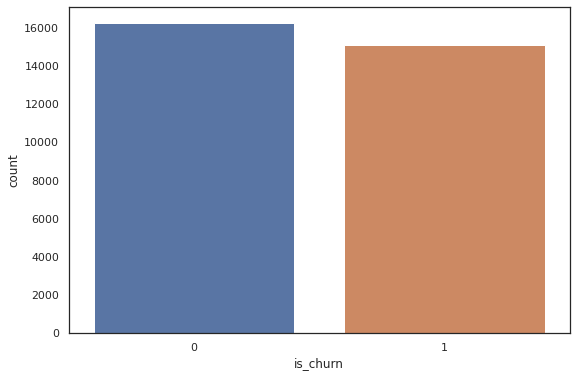

In [255]:
# Imbalance Data

# Observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(df_final.is_churn)

#The imbalanced data is solved by using stratified k-fold

<AxesSubplot:>

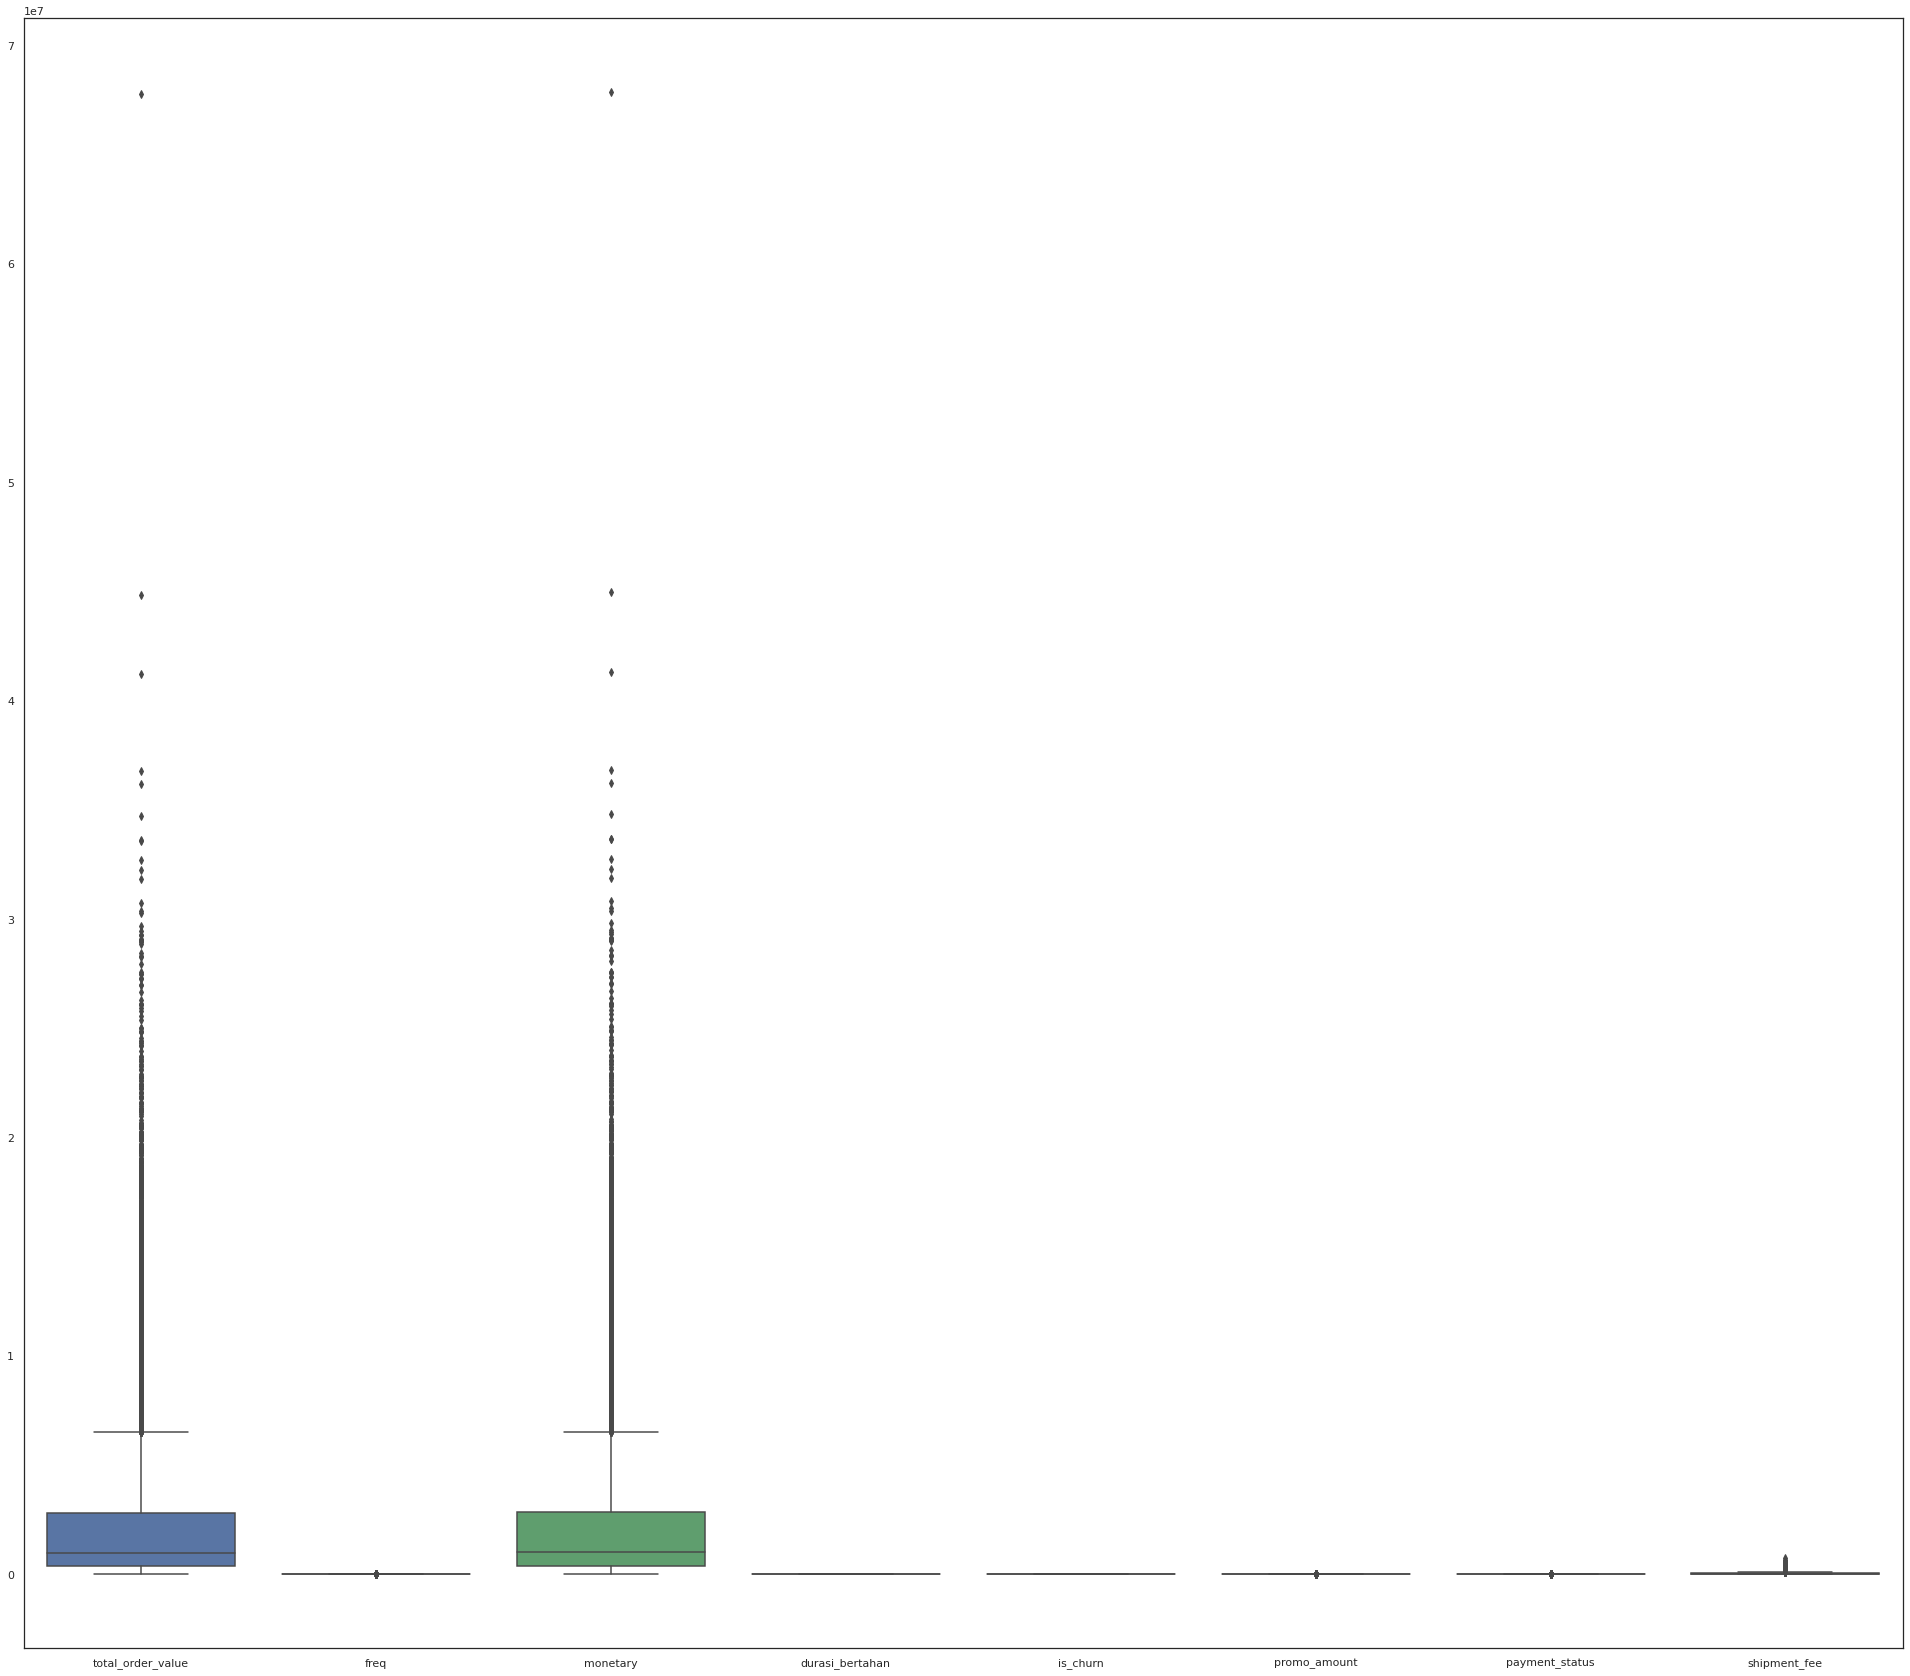

In [256]:
# Cek outlier Box Plot
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(data=df_final)

In [257]:
# Z-Score
columns = list(df_final.columns.values)

for i in columns:
    upper_limit = df_final[i].mean() + 3*df_final[i].std()
    lower_limit = df_final[i].mean() - 3*df_final[i].std()

    df_final[i] = np.where(
        df_final[i]>upper_limit,
        upper_limit,
        np.where(
            df_final[i]<lower_limit,
            lower_limit,
            df_final[i]
        )
    )

<AxesSubplot:>

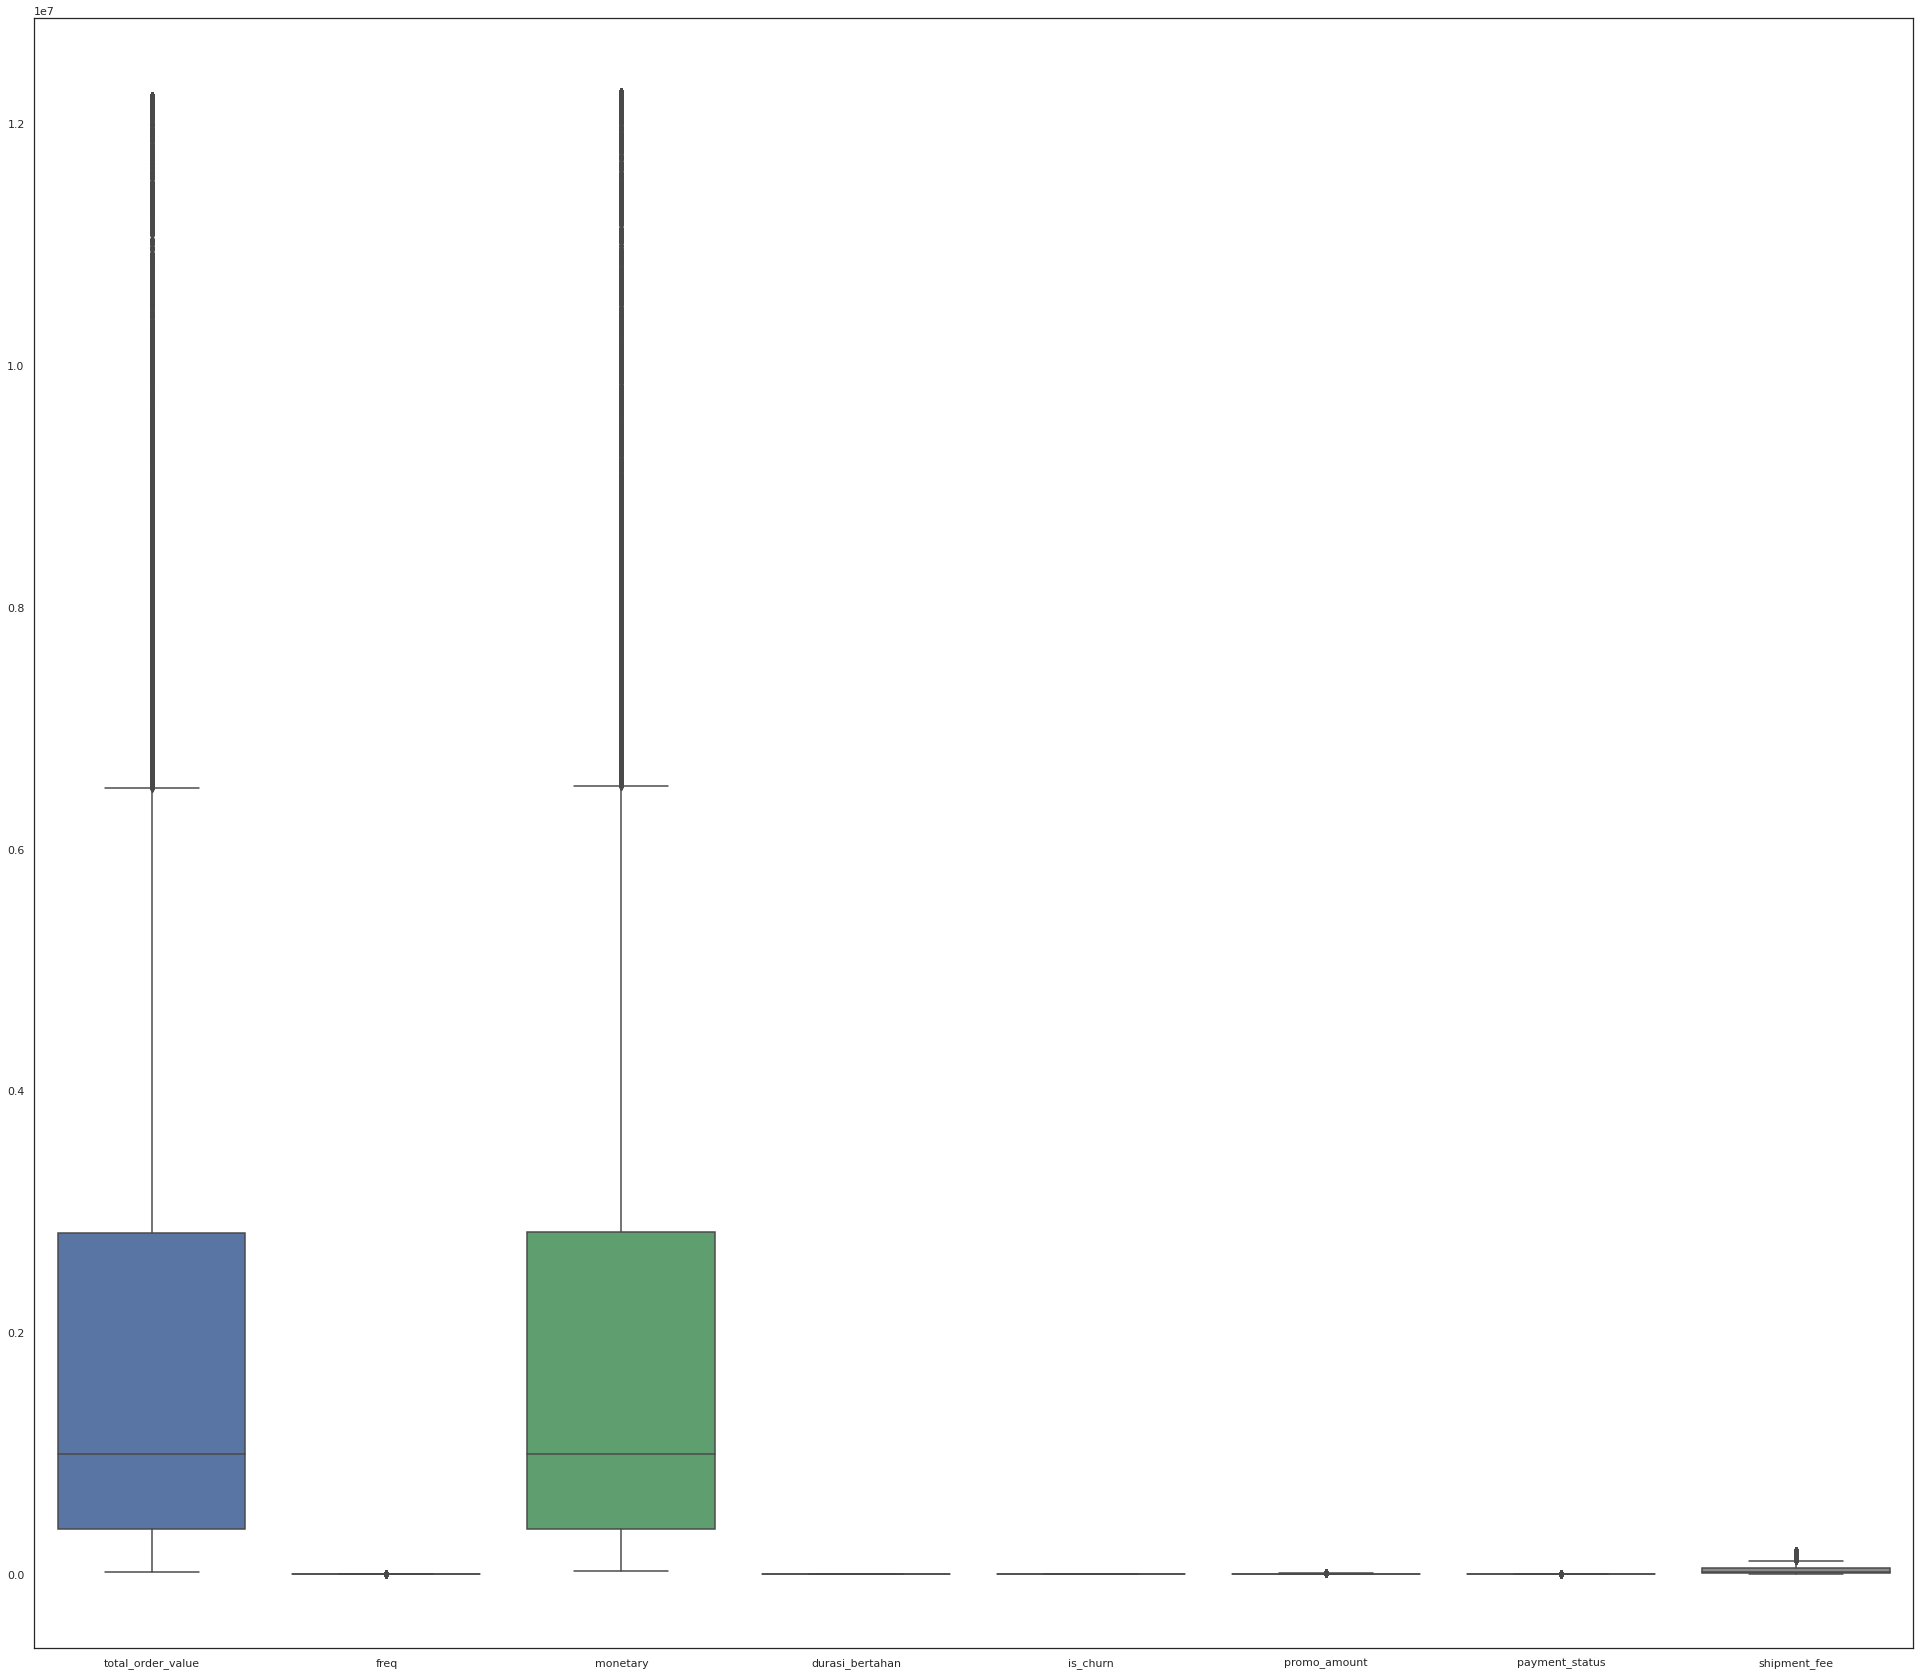

In [258]:
# Cek outlier Box Plot
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(data=df_final)

<AxesSubplot:>

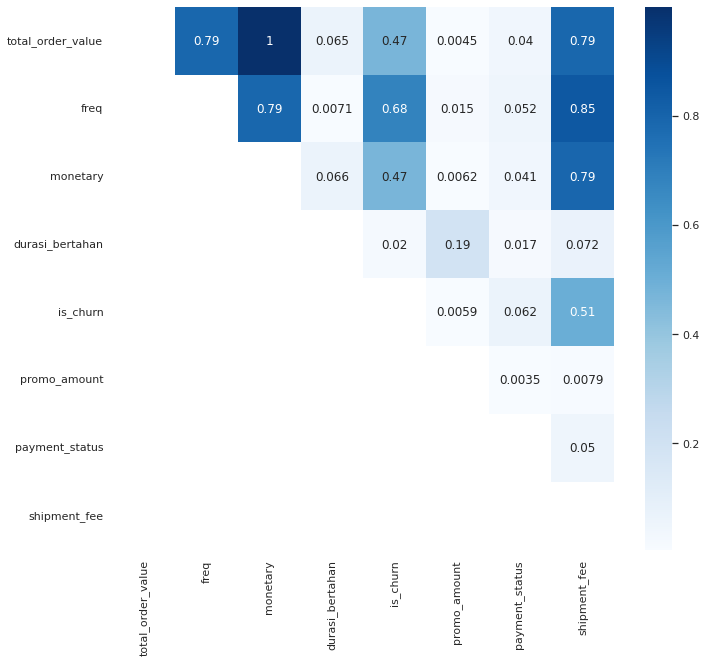

In [259]:
# Create correlation matrix
corr_matrix = df_final.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

plt.figure(figsize=(10,10))
sns.heatmap(upper, annot=True, cmap='Blues')

In [260]:
# error

In [261]:
df_final=df_final.drop(columns = ['shipment_fee','total_order_value'])

<AxesSubplot:>

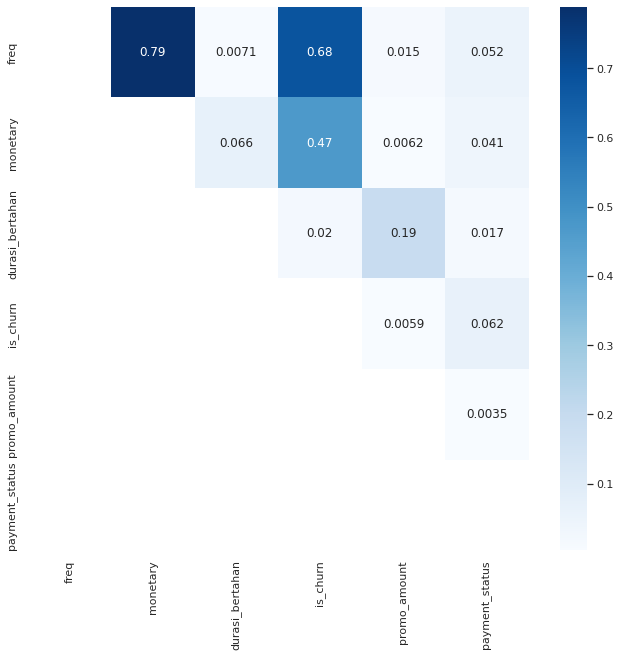

In [262]:
# Create correlation matrix
corr_matrix = df_final.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

plt.figure(figsize=(10,10))
sns.heatmap(upper, annot=True, cmap='Blues')

# Modelling

In [263]:
# Memisahkan mana X dan mana y
y= df_final['is_churn']
X= df_final.drop(['is_churn'],1)
X.head()

,freq,monetary,durasi_bertahan,promo_amount,payment_status
0,0.791608,2782813.0,1177.0,2269.250000,1.0
1,2.143211,8592748.0,1186.0,2007.416667,1.0
2,0.574349,616740.0,1174.0,4915.000000,1.0
3,1.654716,7181844.0,1177.0,1441.384615,1.0
4,0.092875,2463050.0,1120.0,2783.500000,1.0


In [264]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
31354    0.0
31355    1.0
31356    1.0
31357    1.0
31358    1.0
Name: is_churn, Length: 31359, dtype: float64

In [265]:
#Machine learning Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [266]:
#Cross Validation -> Untuk menangani data yang tidak balance
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold

In [267]:
#Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix

In [268]:
# Modelling Algorithms

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

## Collect all model in one list
all_model = [
            DecisionTreeClassifier,
            LogisticRegression,
             KNeighborsClassifier,
             GaussianNB,
#             SVC,
            LinearSVC,
            RandomForestClassifier,
            GradientBoostingClassifier,
            ExtraTreesClassifier,
             XGBClassifier
            ]

model_name = [
        'DecisionTreeClassifier',
            'LogisticRegression',
             'KNeighborsClassifier',
             'GaussianNB',
#             'SVC',
            'LinearSVC',
            'RandomForestClassifier',
            'GradientBoostingClassifier',
            'ExtraTreesClassifier',
             'XGBClassifier'
             ]
## loop for all model

datatr = []
datasc = []
Recall =[]
Precision =[]
auc =[]

for idx, model_type in enumerate(all_model):
    num = 1
    AccTrain = []
    AccTest = []
    RecallTemp = []
    PrecisionTemp = []
    AucTemp = []
    nfold = 1
    for train_index,test_index in kf.split(X,y): 

        print("----------BEFORE------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        model = model_type()
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        AccTrain.append(model.score(X_train , y_train))
        AccTest.append(model.score(X_test , y_test))
        RecallTemp.append(recall_score(y_test,y_pred))
        PrecisionTemp.append(precision_score(y_test,y_pred))
        AucTemp.append(roc_auc_score(y_test, y_pred))
        
        print("----------AFTER------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        nfold += 1
    
    print("----------FINAL------------")
    print("{} Acc Train: {}".format(model_name[idx], np.mean(AccTrain)))
    print("{} Acc Test: {}".format(model_name[idx], np.mean(AccTest)))
    print("{} Recall: {}".format(model_name[idx], np.mean(RecallTemp)))
    print("{} Precission: {}".format(model_name[idx], np.mean(PrecisionTemp)))
    print("{} AUC: {}".format(model_name[idx], np.mean(AucTemp)))
    print("---------------------------")
    datatr.append(np.mean(AccTrain))
    datasc.append(np.mean(AccTest))
    Recall.append(np.mean(RecallTemp))
    Precision.append(np.mean(PrecisionTemp))
    auc.append(np.mean(AucTemp))

----------BEFORE------------
DecisionTreeClassifier Acc Train: [], 1 of KFold 5
DecisionTreeClassifier Acc Test: [], 1 of KFold 5
DecisionTreeClassifier Recall: [], 1 of KFold 5
DecisionTreeClassifier Precission: [], 1 of KFold 5
DecisionTreeClassifier AUC: [], 1 of KFold 5
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: [1.0], 1 of KFold 5
DecisionTreeClassifier Acc Test: [0.9866071428571429], 1 of KFold 5
DecisionTreeClassifier Recall: [0.9850993377483444], 1 of KFold 5
DecisionTreeClassifier Precission: [0.9870603848706039], 1 of KFold 5
DecisionTreeClassifier AUC: [0.9865533589110725], 1 of KFold 5
---------------------------
----------BEFORE------------
DecisionTreeClassifier Acc Train: [1.0], 2 of KFold 5
DecisionTreeClassifier Acc Test: [0.9866071428571429], 2 of KFold 5
DecisionTreeClassifier Recall: [0.9850993377483444], 2 of KFold 5
DecisionTreeClassifier Precission: [0.9870603848706039], 2 of KFold 5
DecisionTreeClassifier AUC: [0.98

In [269]:
## compare model each other
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['Accuracy training'] = datatr
data_hasil['Accuracy test'] = datasc
data_hasil['Precision'] = Precision
data_hasil['Recall']= Recall
data_hasil['AUC']=auc
data_hasil['gap'] = abs(data_hasil['Accuracy training'] - data_hasil['Accuracy test'])
data_hasil.sort_values(by='Accuracy test',ascending=False)

,model,Accuracy training,Accuracy test,Precision,Recall,AUC,gap
8,XGBClassifier,0.999753,0.991645,0.993362,0.989273,0.991561,0.008108
6,GradientBoostingClassifier,0.989564,0.987021,0.990135,0.982850,0.986873,0.002543
5,RandomForestClassifier,1.000000,0.986256,0.988942,0.982453,0.986121,0.013744
0,DecisionTreeClassifier,1.000000,0.985076,0.984588,0.984440,0.985054,0.014924
7,ExtraTreesClassifier,1.000000,0.984247,0.987329,0.979871,0.984092,0.015753
1,LogisticRegression,0.737476,0.738798,0.738645,0.698702,0.737369,0.001322
2,KNeighborsClassifier,0.806363,0.729137,0.717936,0.720699,0.728837,0.077227
3,GaussianNB,0.708951,0.708887,0.635248,0.928883,0.716702,0.000064
4,LinearSVC,0.491247,0.491597,0.568957,0.805960,0.502734,0.000350


In [270]:
y.value_counts()

0.0    16257
1.0    15102
Name: is_churn, dtype: int64

In [271]:
import warnings
warnings.filterwarnings('ignore')

# Hyperparameter Tuning

In [272]:
#Grid Search
from sklearn.model_selection import GridSearchCV

In [273]:
#Grid Search RandomForestClassifier


model = RandomForestClassifier()

param = dict()
param['n_estimators']= [100]
param['criterion'] = ['entropy', 'gini']
param['bootstrap'] = [True, False]
param['max_depth'] = [6]
param['max_features'] = ['auto', 'sqrt']

cv = StratifiedKFold(n_splits=5)
clfRF = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfRF.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.984 total time=   2.8s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.984 total time=   2.9s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.984 total time=   3.0s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.985 total time=   2.9s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.982 total time=   2.8s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.984 total time=   3.0s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.985 total time=   2.8s
[CV 3/5] END bootstrap=True, c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'], 'max_depth': [6],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=4)

In [274]:
print('Best Score: {}'.format(clfRF.best_score_))
print('Best Hyperparameters: {}'.format(clfRF.best_params_))

Best Score: 0.9844382771845781
Best Hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}


In [275]:
#Grid Search GradientBoosting


model = GradientBoostingClassifier()

param = dict()
param['loss']= ["deviance"]
param['learning_rate'] = [0.025, 0.075, 0.2]
param['criterion'] = ["friedman_mse"]
param['max_depth'] = [3, 8]
param['n_estimators'] = [10]

cv = StratifiedKFold(n_splits=5)
clfGB = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfGB.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=3, n_estimators=10;, score=0.982 total time=   0.5s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=3, n_estimators=10;, score=0.982 total time=   0.5s
[CV 3/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=3, n_estimators=10;, score=0.982 total time=   0.5s
[CV 4/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=3, n_estimators=10;, score=0.984 total time=   0.5s
[CV 5/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=3, n_estimators=10;, score=0.981 total time=   0.5s
[CV 2/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=8, n_estimators=10;, score=0.984 total time=   0.7s
[CV 1/5] END criterion=friedman_mse, learning_rate=0.025, loss=deviance, max_depth=8, n_estimators=10;, score=0.984 total time=   

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.025, 0.075, 0.2],
                         'loss': ['deviance'], 'max_depth': [3, 8],
                         'n_estimators': [10]},
             scoring='accuracy', verbose=4)

In [276]:
print('Best Score: {}'.format(clfGB.best_score_))
print('Best Hyperparameters: {}'.format(clfGB.best_params_))

Best Score: 0.9871169045476587
Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'n_estimators': 10}


In [277]:
#Grid Search XGBClassifier


model = XGBClassifier()

param = dict()
param['min_child_weight']= [1, 10]
param['gamma'] = [1, 2]
# param['subsample'] = [0.6, 1.0]
# param['colsample_bytree'] = [0.3, 1.0]
param['max_depth'] = [4, 5]

cv = StratifiedKFold(n_splits=5)
clfXGB = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clfXGB.fit(X,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END gamma=1, max_depth=4, min_child_weight=1;, score=0.988 total time=   2.3s
[CV 3/5] END gamma=1, max_depth=4, min_child_weight=1;, score=0.989 total time=   2.4s
[CV 2/5] END gamma=1, max_depth=4, min_child_weight=1;, score=0.989 total time=   2.4s
[CV 4/5] END gamma=1, max_depth=4, min_child_weight=1;, score=0.991 total time=   2.4s
[CV 1/5] END gamma=1, max_depth=4, min_child_weight=10;, score=0.985 total time=   2.2s
[CV 3/5] END gamma=1, max_depth=4, min_child_weight=10;, score=0.987 total time=   2.1s
[CV 2/5] END gamma=1, max_depth=4, min_child_weight=10;, score=0.986 total time=   2.2s
[CV 5/5] END gamma=1, max_depth=4, min_child_weight=1;, score=0.990 total time=   2.4s
[CV 4/5] END gamma=1, max_depth=4, min_child_weight=10;, score=0.988 total time=   2.2s
[CV 5/5] END gamma=1, max_depth=4, min_child_weight=10;, score=0.987 total time=   2.2s
[CV 1/5] END gamma=1, max_depth=5, min_child_weight=1;, score=0.9

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interacti...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [278]:
print('Best Score: {}'.format(clfXGB.best_score_))
print('Best Hyperparameters: {}'.format(clfXGB.best_params_))

Best Score: 0.9894448428789471
Best Hyperparameters: {'gamma': 1, 'max_depth': 4, 'min_child_weight': 1}


In [279]:
#Train-Test Split
from sklearn.model_selection import train_test_split

In [280]:
#Pisahin X, y jadi X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train dataset shape: ", X_train.shape)
print("y_train dataset shape: ", y_train.shape)
print("X_test dataset shape: ", X_test.shape)
print("y_test dataset shape: ", y_test.shape)

X_train dataset shape:  (25087, 5)
y_train dataset shape:  (25087,)
X_test dataset shape:  (6272, 5)
y_test dataset shape:  (6272,)


In [281]:
# Buat Model Pakai Best Param Dari GridSearchCV
modeltun = XGBClassifier(**clfXGB.best_params_)

In [282]:
# Melatih Model Pakai data train kita
model_fit = modeltun.fit(X_train,y_train)

In [283]:
# Cek Peforma model kita di data latih
y_pred_train=model_fit.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13002
         1.0       1.00      1.00      1.00     12085

    accuracy                           1.00     25087
   macro avg       1.00      1.00      1.00     25087
weighted avg       1.00      1.00      1.00     25087



In [284]:
# Cek Peforma model kita di data test
y_pred_test=model_fit.predict(X_test)
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3255
         1.0       0.99      0.99      0.99      3017

    accuracy                           0.99      6272
   macro avg       0.99      0.99      0.99      6272
weighted avg       0.99      0.99      0.99      6272



# Feature Importance

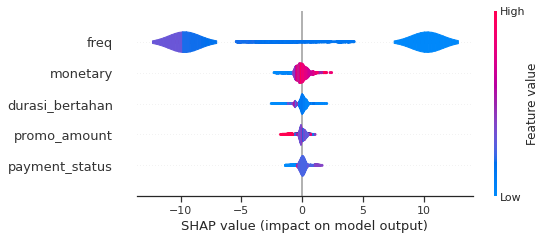

In [285]:
import shap

shap_values = shap.TreeExplainer(model_fit).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="violin")

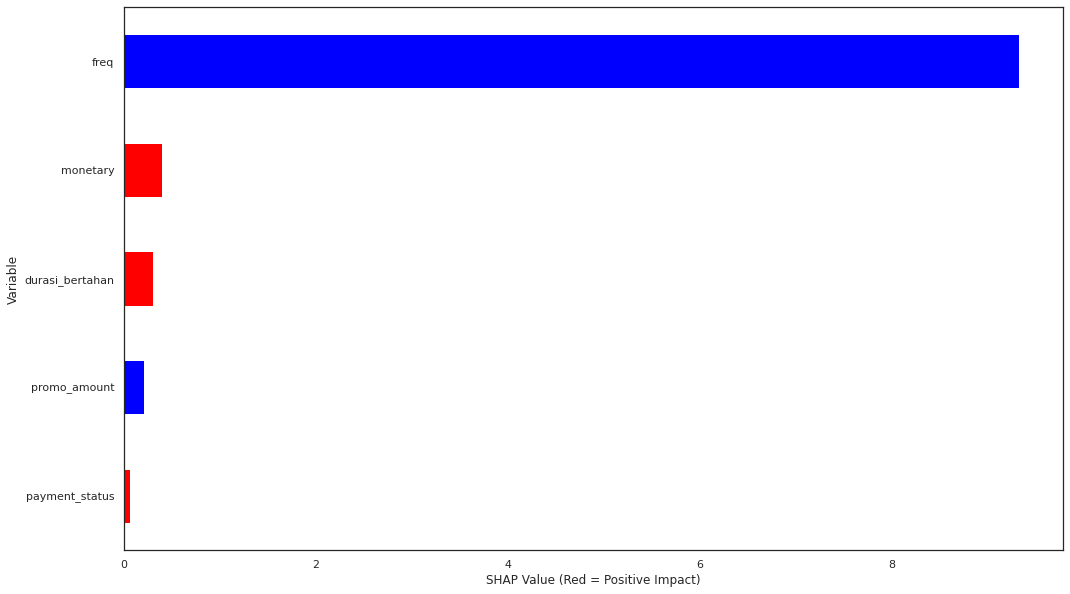

In [286]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',figsize=(15, 10),color = colorlist,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

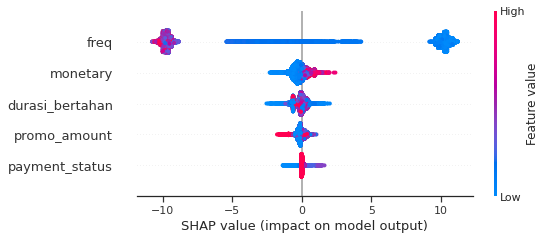

In [287]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

Berdasarkan karakteristik diatas maka
1. Semakin tinggi nilai `freq` semakin rendah churn rate
2. Semakin tinggi nilai `monetary` semakin tinggi churn rate
3. Semakin tinggi nilai `durasi_bertahan` semakin rendah churn rate
4. Semakin tinggi nilai `total_order_value` semakin tinggi churn rate
5. Semakin tinggi nilai `payment_status` semakin rendah churn rate
6. Semakin tinggi nilai `promo_amount` semakin tinggi churn rate

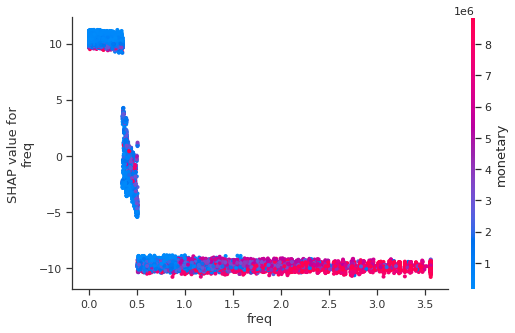

In [288]:
shap.dependence_plot('freq', shap_values, X_train)

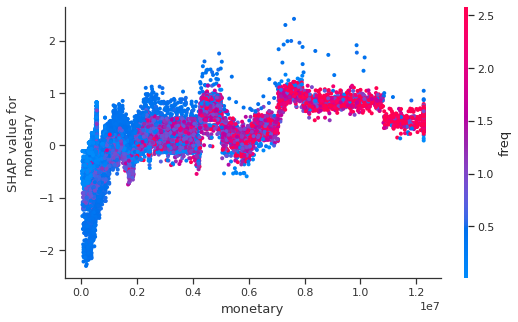

In [289]:
shap.dependence_plot('monetary', shap_values, X_train)

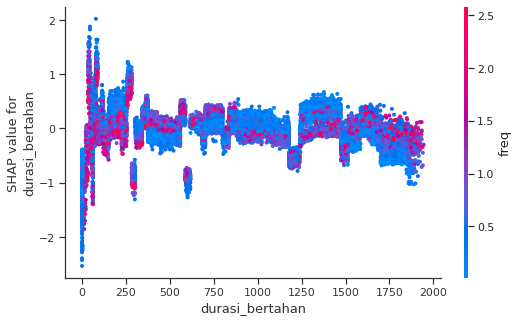

In [290]:
shap.dependence_plot('durasi_bertahan', shap_values, X_train)

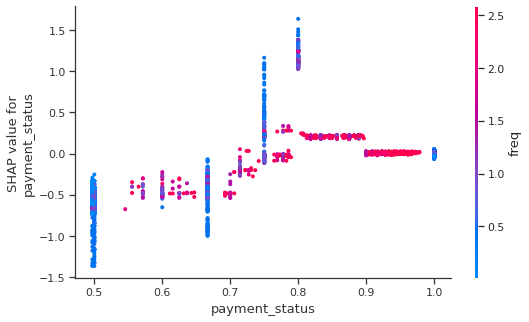

In [291]:
shap.dependence_plot('payment_status', shap_values, X_train)

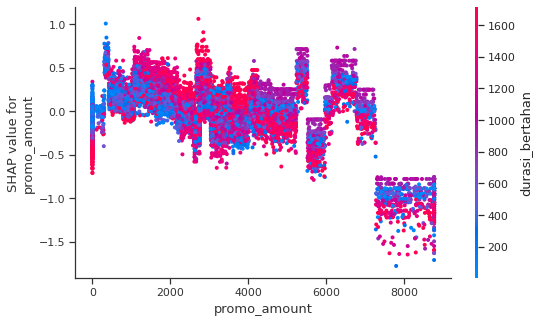

In [292]:
shap.dependence_plot('promo_amount', shap_values, X_train)